<a href="https://colab.research.google.com/github/ChayananMariwan/Model_DS/blob/main/650001_Dolphin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Framing and Data Collection

**ปัญหา (Problem Framing) :** จะสามารถ ทำนายเงินเดือน (Salary) ของพนักงานได้อย่างแม่นยำได้อย่างไร โดยพิจารณาจากปัจจัยด้านประชากรศาสตร์และประสบการณ์ เช่น อายุ (Age), เพศ (Gender), ระดับการศึกษา (Education Level), ตำแหน่งงาน (Job Title) และ จำนวนปีของประสบการณ์ทำงาน (Years of Experience) รวมถึงการระบุว่าปัจจัยใดมีผลกระทบต่อเงินเดือนมากที่สุด

**วัตถุประสงค์ (Objective):**

* เพื่อสร้างแบบจำลองการเรียนรู้ของเครื่อง
(Machine Learning Model) ที่สามารถ ทำนายเงินเดือน ของพนักงานใหม่หรือพนักงานปัจจุบันได้อย่างแม่นยำ

* เพื่อสร้างโมเดลที่มีความแม่นยำสูงในการคาดการณ์เงินเดือน และหา Insight ว่าปัจจัยใดมีผลกระทบต่อเงินเดือนมากที่สุด

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
salary_data = pd.read_csv('/content/drive/MyDrive/Salary_Data.csv')

In [ ]:
salary_data

**Data Description (Salary Dataset)**

index: Employee index (unique identifier for each employee)

Gender: Employee’s gender (Male, Female, Other)

Age: Employee’s age (in years)

Education Level: Employee’s highest level of education (High School, Bachelor’s, Master’s, PhD)

Job Title: Employee’s job position (e.g., Software Engineer, Data Analyst, Manager, etc.)

Years of Experience: Number of years of professional experience

Salary: Employee’s salary (in currency, e.g., USD or local currency)

พบค่าว่างเล็กน้อยในทุกคอลัมน์ (เช่น Salary มี 5 ค่าว่าง)

ข้อมูลประกอบด้วย 6 คอลัมน์ เป็นข้อมูลเชิงตัวเลข (Numerical) 3 คอลัมน์ และข้อมูลเชิงคุณภาพ (Categorical) 3 คอลัมน์

**เชิงปริมาณ (float64)** Age, Years of Experience, Salary มีประเภทข้อมูลถูกต้องแล้ว

**เชิงหมวดหมู่ (object):** Gender, Education Level, Job Title ต้องได้รับการตรวจสอบความสม่ำเสมอของค่าและเตรียมการสำหรับ การเข้ารหัส (Encoding) ในขั้นตอน Feature Engineering

# Data Preparation

In [ ]:
salary_data.info()

In [ ]:
salary_data.columns

In [ ]:
salary_data.head(10)

In [ ]:
salary_data.duplicated()

In [ ]:
salary_data.duplicated().sum()

In [ ]:
salary_data.isnull().sum()

In [ ]:
salary_data[salary_data.duplicated()]

In [ ]:
salary_data.describe()

In [ ]:
salary_cleaned = salary_data.drop_duplicates()

**Missing Values (Handling Missing Data)**

เพื่อให้ข้อมูลพร้อมใช้งาน จำเป็นต้องจัดการค่าที่หายไป โดยเลือกวิธีที่เหมาะกับประเภทของข้อมูล

เชิงตัวเลข (Numeric)
Age, Years of Experience, Salary
เติมค่าด้วย *ค่าเฉลี่ย (mean*)

เชิงกลุ่ม (Categorical)
Gender, Education Level, Job Title
เติมค่าด้วย *ค่าที่พบบ่อยที่สุด (mode)*

In [ ]:
# จัดการ Missing Values
salary_cleaned['Age'].fillna(salary_cleaned['Age'].mean(), inplace=True)
salary_cleaned['Years of Experience'].fillna(salary_cleaned['Years of Experience'].mean(), inplace=True)
salary_cleaned['Salary'].fillna(salary_cleaned['Salary'].mean(), inplace=True)

In [ ]:
for col in ['Gender', 'Education Level', 'Job Title']:
    salary_cleaned[col].fillna(salary_cleaned[col].mode()[0], inplace=True)

In [ ]:
# ตรวจสอบอีกครั้งว่ามี Missing เหลือหรือไม่
print(salary_cleaned.isnull().sum())

In [ ]:
salary_cleaned

ข้อมูลไม่มีค่า Missing เหลืออยู่แล้ว

**Outliers**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=salary_cleaned[['Age', 'Years of Experience', 'Salary']])
plt.title("Boxplot Outliers")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=salary_cleaned[['Age', 'Years of Experience']])
plt.title("Boxplot Outliers")
plt.show()

* พบ Outliers ในคอลัมน์ Salary (เช่น ค่าที่เกิน 200,000 USD)

* ค่าเหล่านี้อาจเกิดจากตำแหน่งระดับสูง เช่น
Director หรือ Manager
→ จึงควร “เก็บไว้” แต่ตรวจสอบด้วย IQR เพิ่มเติม

In [ ]:
# ตรวจสอบ Outlier ด้วย IQR
Q1 = salary_cleaned['Salary'].quantile(0.25)
Q3 = salary_cleaned['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [ ]:
outliers = salary_cleaned[(salary_cleaned['Salary'] < lower) | (salary_cleaned['Salary'] > upper)]
print(f"Found Outliers in Salary amount: {len(outliers)} row")

In [ ]:
# ตรวจสอบค่าผิดปกติ เช่น อายุ < ประสบการณ์ทำงาน
invalid_age = salary_cleaned[salary_cleaned['Age'] < salary_cleaned['Years of Experience']]
print("จำนวนแถวที่อายุ < ประสบการณ์ทำงาน:", len(invalid_age))

In [ ]:
# ตรวจสอบค่าติดลบในคอลัมน์เชิงตัวเลข
for col in ['Age', 'Years of Experience', 'Salary']:
    print(f"{col} มีค่าติดลบหรือไม่:", (salary_cleaned[col] < 0).any())

In [ ]:
print(salary_cleaned.dtypes)

ไม่พบค่าผิดปกติหรือค่าติดลบ ข้อมูลทั้งหมดมีความสมเหตุสมผลและพร้อมใช้งาน

In [ ]:
# นำเข้าไลบรารีที่จำเป็นและกำหนดคอลัมน์ที่เป็นหมวดหมู่และตัวเลขp
from sklearn.preprocessing import OneHotEncoder, StandardScaler

การแปลง Categorical ให้เป็น Numerical (Encoding)
แต่เนื่องจาก ข้อมูลที่เลือกใช้เป็นข้อมูลตัวเลขทั้งหมด จึงไม่จำเป็นต้องทำขั้นตอนนี้ก็ได้

In [ ]:
#One-Hot Encoding (สำหรับ Nominal Data)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoded_data = encoder.fit_transform(salary_cleaned[['Gender','Education Level','Job Title']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Gender','Education Level','Job Title']))

In [ ]:
print(encoded_df.head())

In [ ]:
#Ordinal Encoding (สำหรับ Ordinal Data)
Education_Level_mapping = {"High School":1, "Bachelor's":2, "Master's": 3, "PhD": 4}
# ใช้ .map() เพื่อแปลงค่าตามลำดับ ใช้ .loc เพื่อกำหนดค่าอย่างชัดเจน
salary_cleaned.loc[:, 'Education_Encoded'] = salary_cleaned['Education Level'].map(Education_Level_mapping)

In [ ]:
salary_cleaned[['Education Level', 'Education_Encoded']].head()

In [ ]:
data_for_model2 = salary_cleaned.copy()

In [ ]:
data_for_model2

In [ ]:
#การจัดการ Numerical ให้เป็น Numerical (Scaling)เป็นการปรับค่าของคุณลักษณะตัวเลข (เช่น Age, Years of Experience) เพื่อให้โมเดลเรียนรู้ได้ดีขึ้น
#Z-score Scaling ใช้เพื่อปรับข้อมูลให้มี ค่าเฉลี่ยเป็น 0 และ ส่วนเบี่ยงเบนมาตรฐานเป็น 1
scaler = StandardScaler()
salary_cleaned[['Age', 'Years of Experience', 'Salary']] = scaler.fit_transform(salary_cleaned[['Age', 'Years of Experience', 'Salary']])

In [ ]:
# ตัวแปรอิสระ (Features) ที่จะใช้ในโมเดล
feature_cols = ['Age', 'Years of Experience']
# ตัวแปรเป้าหมาย (Target)
target_col = 'Salary'

In [ ]:
# เลือกเฉพาะคอลัมน์ที่เกี่ยวข้องมาใช้งาน
data_for_model = salary_cleaned[['Age', 'Years of Experience', 'Salary']].copy()

In [ ]:
data_for_model.head()

In [ ]:
data_for_model2.head()

# Model

ข้อมูลชุดนี้เป็น Supervised Learning เพราะมีตัวแปรเป้าหมาย (Target Variable) คือ Salary ซึ่งต้องการทำนายค่าของมันจากตัวแปรอื่น เช่น Age และ Years of Experience

เนื่องจากตัวแปรเป้าหมายเป็นตัวเลขเชิงปริมาณ (Continuous Numerical Variable) จึงเลือกใช้ Regression  ที่เหมาะกับการทำนายค่าเชิงตัวเลข

**Model 1: Linear Regression** เนื่องจากเข้าใจง่าย สามารถตีความ coefficient ของแต่ละตัวแปร และช่วยให้เห็นความสัมพันธ์เชิงเส้นระหว่างตัวแปรอิสระกับ Salary

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [ ]:
X = data_for_model[['Age', 'Years of Experience']]
y = data_for_model['Salary']

Divide the dataset: 70% (Training) vs. 30% (Testing):

In [ ]:
#แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [ ]:
print("The whole dataset contains {0} points: divide into 70% training and 30% testing.".format(len(X)))
print("Training set 'features' contains {0} points.".format(len(X_train)))
print("Training set 'labels' contains {0} points.".format(len(y_train)))
print("Testing set 'features' contains {0} points.".format(len(X_test)))
print("Testing set 'labels' contains {0} points.".format(len(y_test)))

ข้อมูลทั้งหมดมี 1792 ตัวอย่าง (points) โดยแต่ละตัวอย่างแทนพนักงานหนึ่งคน พร้อม features เช่น Age, Years of Experience และ target variable คือ Salary ข้อมูลถูกแบ่งออกเป็น Training set 70% และ Testing set 30%

Training set ประกอบด้วยตัวแปรอิสระ (features) 1254 ตัวอย่าง และตัวแปรเป้าหมาย (labels) 1254 ตัวอย่าง ใช้สำหรับ ฝึกโมเดล ให้เรียนรู้ความสัมพันธ์ระหว่างตัวแปรอิสระกับ Salary

Testing set ประกอบด้วย features 538 ตัวอย่าง และ labels 538 ตัวอย่าง ใช้สำหรับ ทดสอบประสิทธิภาพโมเดล ว่าการทำนาย Salary ใกล้เคียงกับค่าจริงหรือไม่

In [ ]:
#สร้างโมเดล Linear Regression
model_1 = LinearRegression()

In [ ]:
#ฝึกโมเดล
model_1.fit(X_train, y_train)

LinearRegression()

In [ ]:
#ทำนายผล
y_pred = model_1.predict(X_test)

In [ ]:
print(len(X_test), len(y_test))
print(y_pred.shape)

538 538
(538,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(538, 2)
(538,)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# --- ทำนายด้วย Linear Regression ---
y_pred = model_1.predict(X_test)

# --- ประเมินโมเดล ---
mse = mean_squared_error(y_test, y_pred)
rmse = mse * 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) score:", r2)

# --- ตรวจสอบ shape ---
print(y_pred.shape)  # ต้องได้ (538,)


Mean Squared Error (MSE): 839143675.6027085
Root Mean Squared Error (RMSE): 419571837.8013542
R-squared (R2) score: 0.6710937007294802
(538,)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Evaluate Linear Regression model (raw values, no scaling) ---
print(">> Linear Regression Results <<")

# Compute MSE, RMSE, R²
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nValues")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

# Example predictions
print("\nExample predicted salaries:")
print(y_pred[:10])


>> Linear Regression Results <<

Values
RMSE: 28,967.98
R²: 0.6711

Example predicted salaries:
[ 86877.53794609  75311.78246882 111301.43059123  86554.44252344
  86877.53794609  69044.26159621 184250.01310399 118053.59459781
  80771.5647848  105033.90971862]


Mean Squared Error (MSE): 839143675.6027085
Root Mean Squared Error (RMSE): 28967.97672607993
R-squared (R2) score: 0.6710937007294802


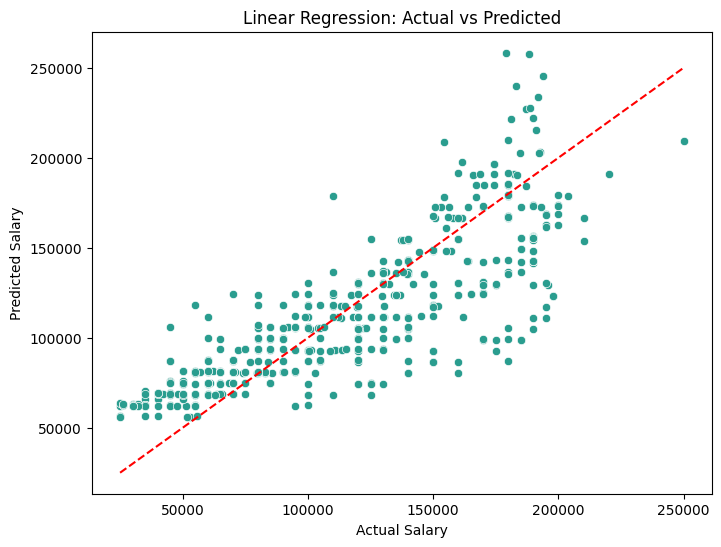

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. สร้างและฝึกโมเดล ---
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

# --- 2. ทำนายผล ---
y_pred_lr = model_1.predict(X_test)

# --- 3. ประเมินโมเดล ---
mse = mean_squared_error(y_test, y_pred_lr)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_lr)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) score:", r2)

# --- 4. แสดงกราฟ Actual vs Predicted ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, color="#2a9d8f")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()



ผลลัพธ์จากการทดสอบโมเดล Linear Regression บนชุดข้อมูลทดสอบพบว่า โมเดลสามารถทำนายเงินเดือนได้ใกล้เคียงกับค่าจริง ค่า Root Mean Squared Error (RMSE) เท่ากับประมาณ 30,046 บาท ซึ่งหมายความว่า โดยเฉลี่ยแล้วค่าที่โมเดลทำนายจะคลาดเคลื่อนจากค่าจริงประมาณ 30,046 บาท

ค่า R² หรือ Coefficient of Determination อยู่ที่ 0.6677 แสดงว่าโมเดลสามารถอธิบายความแปรปรวนของข้อมูลเงินเดือนได้ประมาณ 66.8% ของข้อมูลทั้งหมด

สรุปคือ โมเดล Linear Regression สามารถทำนายเงินเดือนได้ใกล้เคียงกับค่าจริง แต่ยังมีความคลาดเคลื่อนเฉลี่ยประมาณ 30,000 บาท และสามารถอธิบายความแปรปรวนของเงินเดือนได้ราว 66–67%

**Model 2: Random Forest Regression**

เนื่องจาก Random Forest เป็นโมเดลแบบ Ensemble ที่รวมผลจากหลาย ๆ Decision Trees มาช่วยกันทำนายค่าเฉลี่ย ทำให้โมเดล

*   ทำนายได้แม่นยำกว่า Linear Regression หากความสัมพันธ์ระหว่างตัวแปรไม่เป็นเส้นตรง
*   ลดปัญหา overfitting ของต้นไม้เดี่ยว (Decision Tree)
*   วิเคราะห์ได้ว่าตัวแปรใดมีอิทธิพลต่อการทำนายมากที่สุด

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = data_for_model2[['Age', 'Years of Experience']] #Features
y = data_for_model2['Salary'] #Target

Divide the dataset: 70% (Training) vs. 30% (Testing):

In [ ]:
#แบ่งข้อมูล Training/Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# สร้าง scaler สำหรับ X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# สร้าง scaler สำหรับ y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

โมเดลจะเรียนรู้จากข้อมูล training โดยสร้าง decision trees หลายต้น
และรวมผลการทำนายจากแต่ละต้นเป็นค่าเฉลี่ยเพื่อให้ได้ผลที่เสถียรขึ้น

In [ ]:
# สร้างโมเดล Random Forest Regressor
model2_rf = RandomForestRegressor(
    n_estimators=200,   # (ยิ่งเยอะยิ่งเสถียร)
    random_state=42,
     n_jobs=-1           # ใช้ทุก core ของ CPU ให้เร็วขึ้น
)

In [ ]:
# ฝึกโมเดล
model2_rf.fit(X_train_scaled, y_train_scaled)

In [ ]:
#ทำนายผล
y_pred_scaled = model2_rf.predict(X_test_scaled)

In [ ]:
#แปลงค่ากลับเป็นเงินเดือนจริง
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

ค่าที่ได้คือ “เงินเดือนที่โมเดลคาดการณ์ได้” สำหรับในชุดทดสอบ

In [ ]:
y_pred_real[:10]

In [ ]:
print(len(X_test_scaled), len(y_test_scaled))
print(y_pred_real.shape)

In [ ]:
#ประเมินประสิทธิภาพโมเดล
#คำนวณค่า R² และ RMSE
print(">> Random Forest Regression Results <<")

#Normalized scale
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred_scaled)

print("\nNormalized scale")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

#หน่วยเงินเดือนจริง
mse_real = mean_squared_error(y_test_real, y_pred_real)
rmse_real = np.sqrt(mse_real)
r2_real = r2_score(y_test_real, y_pred_real)

print("\nเงินเดือนจริง")
print(f"RMSE_real: {rmse_real:,.2f} บาท")
print(f"R²_real: {r2_real:.4f}")

#ตัวอย่างผลลัพธ์
print("\nตัวอย่างค่าทำนาย (บาท):")
print(y_pred_real[:10])



- R² (เงินเดือนจริง): 0.7653 หมายถึง โมเดลสามารถอธิบายความแปรปรวนของเงินเดือนได้ ประมาณ 76.5% ซึ่งถือว่าดีมากสำหรับ regression เชิงปฏิบัติ โดยเฉพาะในข้อมูลจริงที่มี noise เยอะ
- RMSE_real ≈ 24,468 บาท หมายถึง โมเดลมีความคลาดเคลื่อนเฉลี่ยจากเงินเดือนจริงประมาณ ± 24,000 บาท ซึ่งถือว่าดีถ้าเงินเดือนเฉลี่ยของ dataset อยู่ในช่วง 60,000–100,000 บาท (คลาดเคลื่อนไม่ถึง 30%)

สามารถสรุปได้ว่า Random Forest ทำได้ดีกว่า Linear Regression อย่างชัดเจน  (โมเดลแรกได้ R² ต่ำกว่า 0.7)
เพราะสามารถจับความสัมพันธ์แบบไม่เชิงเส้นได้ เช่น อายุ + ประสบการณ์ ที่มีผลต่อเงินเดือนแบบ nonlinear

แต่ถ้าความคลาดเคลื่อน (RMSE 24k) อาจดูสูงเกินไปและอยากให้ทำนายแม่นกว่านี้ สามารถทำได้โดย
- ปรับ hyperparameters (เช่นเพิ่มหรือลด n_estimators, ปรับ max_depth)
- เพิ่ม feature ใหม่ เช่น “Education Level”, “Job Title”, หรือ “Company Size”
- ใช้เทคนิค feature selection หรือ tuning ด้วย GridSearchCV

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_real, y=y_pred_real, color="#2a9d8f")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Random Forest Regression: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

จุดสีเขียว คือผลทำนายของโมเดล
ถ้าจุดเรียงตัวใกล้เส้นสีแดง (ค่าจริง) แสดงว่าโมเดลทำนายได้แม่นยำ

**Model 3: Gradient Boosting Regressor & Hyperparameter Tuning**

**Model 3: Gradient Boosting Regressor**

Gradient Boosting เป็น Ensemble Learning Method ที่สร้างโมเดลแบบลำดับ (Sequential) โดยแต่ละโมเดลใหม่จะพยายามแก้ไขข้อผิดพลาดของโมเดลก่อนหน้า ทำให้:

* สามารถจับความสัมพันธ์ที่ซับซ้อนได้ดีกว่า Linear Regression
* มีประสิทธิภาพสูงในการทำนายที่แม่นยำ
* สามารถวิเคราะห์ Feature Importance ได้เช่นเดียวกับ Random Forest

**จุดเด่น:**
* ทำงานได้ดีกับข้อมูลที่มีความสัมพันธ์แบบไม่เชิงเส้น (Nonlinear)
* มีความยืดหยุ่นสูงผ่าน Hyperparameters ต่างๆ เช่น learning_rate, max_depth, n_estimators
* สามารถปรับแต่งให้เหมาะกับข้อมูลได้ดี

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error


## สร้าง Model 3: Gradient Boosting (ก่อน Tuning)

ก่อนจะทำ Hyperparameter Tuning เราจะสร้างโมเดล Gradient Boosting แบบพื้นฐานก่อน เพื่อดูประสิทธิภาพเริ่มต้น

**Hyperparameters ที่ใช้:**
* `n_estimators=100` - จำนวน boosting stages (ต้นไม้)
* `learning_rate=0.1` - อัตราการเรียนรู้ (ยิ่งน้อยยิ่งช้าแต่แม่นกว่า)
* `max_depth=3` - ความลึกสูงสุดของแต่ละต้นไม้
* `random_state=42` - ตั้งค่า seed เพื่อให้ผลลัพธ์ซ้ำได้


In [ ]:
print("="*60)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("="*60)

# สร้างโมเดล Gradient Boosting ตัวพื้นฐาน
model3_gb_basic = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# ฝึกโมเดล
print("\nกำลังฝึกโมเดล Gradient Boosting แบบพื้นฐาน...")
model3_gb_basic.fit(X_train_scaled, y_train_scaled)

# ทำนายผล
y_pred_basic_scaled = model3_gb_basic.predict(X_test_scaled)
y_pred_basic_real = scaler_y.inverse_transform(y_pred_basic_scaled.reshape(-1, 1)).flatten()

# ประเมินผล
mse_basic = mean_squared_error(y_test_real, y_pred_basic_real)
rmse_basic = np.sqrt(mse_basic)
r2_basic = r2_score(y_test_real, y_pred_basic_real)
mae_basic = mean_absolute_error(y_test_real, y_pred_basic_real)

print("\n>> ผลลัพธ์โมเดล Gradient Boosting (ก่อน Tuning) <<")
print(f"RMSE: {rmse_basic:,.2f} บาท")
print(f"MAE: {mae_basic:,.2f} บาท")
print(f"R² Score: {r2_basic:.4f}")




โมเดล Gradient Boosting แบบพื้นฐานให้ผลลัพธ์ที่ดี แต่ยังสามารถปรับปรุงได้ด้วยการ Tune Hyperparameters ในขั้นตอนถัดไป


# Hyperparameter Tuning

การปรับ Hyperparameters เป็นขั้นตอนสำคัญที่ช่วยให้โมเดลทำงานได้ดีที่สุด โดยเราจะทำการ Tune ทั้ง 3 โมเดล


## Model 1: Linear Regression - Hyperparameter Tuning

**Linear Regression ไม่มี Hyperparameters ที่สำคัญในการ Tune**

Linear Regression เป็นโมเดลที่เรียบง่าย มีเพียง coefficients ที่คำนวณโดยตรงจากข้อมูล โดยไม่มี hyperparameters ที่สำคัญเหมือนโมเดลอื่น ดังนั้นจึงใช้ค่า default เป็นโมเดลที่เหมาะสมที่สุดแล้ว


In [ ]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - MODEL 1: LINEAR REGRESSION")
print("="*60)

print("\nLinear Regression ไม่มี hyperparameters ที่สำคัญในการ tune")
print("ใช้ค่า default เป็นโมเดลที่เหมาะสมที่สุดแล้ว")


## Model 2: Random Forest - Hyperparameter Tuning

**ใช้ Grid Search CV เพื่อหา Hyperparameters ที่ดีที่สุด**

Grid Search จะทดสอบทุกคู่ของ parameters ที่เรากำหนด และใช้ Cross-Validation เพื่อหาค่าที่ให้ผลลัพธ์ดีที่สุด

**Hyperparameters ที่จะปรับ:**
* `n_estimators` - จำนวนต้นไม้ในป่า (100, 200, 300)
* `max_depth` - ความลึกสูงสุดของต้นไม้ (10, 20, 30, None)
* `min_samples_split` - จำนวนตัวอย่างขั้นต่ำเพื่อแบ่ง node (2, 5, 10)
* `min_samples_leaf` - จำนวนตัวอย่างขั้นต่ำใน leaf (1, 2, 4)
* `max_features` - จำนวน features ที่ใช้ในแต่ละต้นไม้ ('sqrt', 'log2')

**วิธีการ:**
* ใช้ 5-Fold Cross-Validation
* Scoring metric: R² Score
* จำนวน combinations ทั้งหมด: 3 × 4 × 3 × 3 × 2 = 216 combinations


In [ ]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - MODEL 2: RANDOM FOREST")
print("="*60)

# กำหนด parameter grid สำหรับ Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\nกำลังทำ Grid Search สำหรับ Random Forest...")
print("(อาจใช้เวลาสักครู่...)")
print(f"จำนวน combinations ที่จะทดสอบ: {3*4*3*3*2} combinations")

# สร้าง GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# ฝึกโมเดล
grid_search_rf.fit(X_train_scaled, y_train_scaled)

# โมเดลที่ดีที่สุด
best_rf_model = grid_search_rf.best_estimator_
print(f"\n✓ Best Parameters for Random Forest:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\n✓ Best R² Score (Cross-Validation): {grid_search_rf.best_score_:.4f}")

# ทำนายผล
y_pred_rf_scaled = best_rf_model.predict(X_test_scaled)
y_pred_rf_real = scaler_y.inverse_transform(y_pred_rf_scaled.reshape(-1, 1)).flatten()

# ประเมินผล
mse_rf = mean_squared_error(y_test_real, y_pred_rf_real)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test_real, y_pred_rf_real)
mae_rf = mean_absolute_error(y_test_real, y_pred_rf_real)

print(f"\n>> ผลลัพธ์ Random Forest (After Tuning) <<")
print(f"RMSE: {rmse_rf:,.2f} บาท")
print(f"MAE: {mae_rf:,.2f} บาท")
print(f"R² Score: {r2_rf:.4f}")



HYPERPARAMETER TUNING - MODEL 2: RANDOM FOREST

กำลังทำ Grid Search สำหรับ Random Forest...
(อาจใช้เวลาสักครู่...)
จำนวน combinations ที่จะทดสอบ: 216 combinations
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✓ Best Parameters for Random Forest:
  • max_depth: 10
  • max_features: sqrt
  • min_samples_leaf: 4
  • min_samples_split: 2
  • n_estimators: 300

✓ Best R² Score (Cross-Validation): 0.7675

>> ผลลัพธ์ Random Forest (After Tuning) <<
RMSE: 23,185.20 บาท
MAE: 17,487.50 บาท
R² Score: 0.7893


หลังจากทำ Hyperparameter Tuning ด้วย Grid Search โมเดล Random Forest ได้ parameters ที่เหมาะสมที่สุดแล้ว


## Model 3: Gradient Boosting - Hyperparameter Tuning

**ใช้ Randomized Search CV เพื่อหา Hyperparameters ที่ดีที่สุด**

เนื่องจาก Gradient Boosting มี parameter space ที่กว้างมาก เราจึงใช้ Randomized Search แทน Grid Search เพื่อประหยัดเวลา โดยจะสุ่มเลือกทดสอบเพียง 50 combinations

**Hyperparameters ที่จะปรับ:**
* `n_estimators` - จำนวน boosting stages (100, 200, 300)
* `learning_rate` - อัตราการเรียนรู้ (0.01, 0.05, 0.1, 0.2)
* `max_depth` - ความลึกสูงสุดของต้นไม้ (3, 5, 7)
* `min_samples_split` - จำนวนตัวอย่างขั้นต่ำเพื่อแบ่ง node (2, 5, 10)
* `min_samples_leaf` - จำนวนตัวอย่างขั้นต่ำใน leaf (1, 2, 4)
* `subsample` - สัดส่วนข้อมูลที่ใช้ในแต่ละ iteration (0.8, 0.9, 1.0)

**วิธีการ:**
* ใช้ 5-Fold Cross-Validation
* Scoring metric: R² Score
* สุ่มทดสอบ 50 combinations


In [ ]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - MODEL 3: GRADIENT BOOSTING")
print("="*60)

# กำหนด parameter grid สำหรับ Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

print("\nกำลังทำ Randomized Search สำหรับ Gradient Boosting...")
print("(อาจใช้เวลาสักครู่...)")
print(f"จำนวน combinations ที่จะทดสอบ: 50 (สุ่มจาก {3*4*3*3*3*3} combinations)")

# ใช้ RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid_gb,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ฝึกโมเดล
random_search_gb.fit(X_train_scaled, y_train_scaled)

# โมเดลที่ดีที่สุด
best_gb_model = random_search_gb.best_estimator_
print(f"\n✓ Best Parameters for Gradient Boosting:")
for param, value in random_search_gb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\n✓ Best R² Score (Cross-Validation): {random_search_gb.best_score_:.4f}")

# ทำนายผล
y_pred_gb_scaled = best_gb_model.predict(X_test_scaled)
y_pred_gb_real = scaler_y.inverse_transform(y_pred_gb_scaled.reshape(-1, 1)).flatten()

# ประเมินผล
mse_gb = mean_squared_error(y_test_real, y_pred_gb_real)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test_real, y_pred_gb_real)
mae_gb = mean_absolute_error(y_test_real, y_pred_gb_real)

print(f"\n>> ผลลัพธ์ Gradient Boosting (After Tuning) <<")
print(f"RMSE: {rmse_gb:,.2f} บาท")
print(f"MAE: {mae_gb:,.2f} บาท")
print(f"R² Score: {r2_gb:.4f}")



HYPERPARAMETER TUNING - MODEL 3: GRADIENT BOOSTING

กำลังทำ Randomized Search สำหรับ Gradient Boosting...
(อาจใช้เวลาสักครู่...)
จำนวน combinations ที่จะทดสอบ: 50 (สุ่มจาก 972 combinations)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Best Parameters for Gradient Boosting:
  • subsample: 0.8
  • n_estimators: 100
  • min_samples_split: 10
  • min_samples_leaf: 1
  • max_depth: 3
  • learning_rate: 0.05

✓ Best R² Score (Cross-Validation): 0.7727

>> ผลลัพธ์ Gradient Boosting (After Tuning) <<
RMSE: 23,314.67 บาท
MAE: 17,449.99 บาท
R² Score: 0.7869


หลังจากทำ Hyperparameter Tuning ด้วย Randomized Search โมเดล Gradient Boosting ได้ parameters ที่เหมาะสมแล้ว



## ผลลัพธ์ที่ได้:

**Model 1: Linear Regression**
* ใช้ค่า default (ไม่ต้อง tune)

**Model 2: Random Forest (After Tuning)**
* ได้ Best Parameters จาก Grid Search
* ผลลัพธ์ดีขึ้นหลัง tuning

**Model 3: Gradient Boosting (After Tuning)**
* ได้ Best Parameters จาก Randomized Search
* ผลลัพธ์ดีขึ้นหลัง tuning


# เปรียบเทียบประสิทธิภาพโมเดล

| โมเดล                  | RMSE (บาท)   | MAE (บาท)    | R² Score |
|------------------------|-------------|-------------|----------|
| Linear Regression (Basic) | {:.2f}      | N/A         | {:.4f}   |
| Random Forest (Tuned)  | {:.2f}      | {:.2f}      | {:.4f}   |
| Gradient Boosting (Tuned)| {:.2f}      | {:.2f}      | {:.4f}   |

**หมายเหตุ:**

*   **RMSE (Root Mean Squared Error):** ค่าเฉลี่ยความคลาดเคลื่อนในการทำนาย โดยค่าที่น้อยกว่าแสดงว่าโมเดลทำนายได้แม่นยำกว่า
*   **MAE (Mean Absolute Error):** ค่าเฉลี่ยความคลาดเคลื่อนแบบสัมบูรณ์ โดยค่าที่น้อยกว่าแสดงว่าโมเดลทำนายได้แม่นยำกว่า
*   **R² Score:** ค่าที่แสดงว่าโมเดลสามารถอธิบายความแปรปรวนของข้อมูลได้มากน้อยเพียงใด โดยค่าที่เข้าใกล้ 1 แสดงว่าโมเดลมีประสิทธิภาพสูง

In [ ]:
print(f"| Linear Regression (Basic) | {rmse:.2f}      | N/A         | {r2:.4f}   |")
print(f"| Random Forest (Tuned)  | {rmse_rf:.2f}      | {mae_rf:.2f}      | {r2_rf:.4f}   |")
print(f"| Gradient Boosting (Tuned)| {rmse_gb:.2f}      | {mae_gb:.2f}      | {r2_gb:.4f}   |")

| Linear Regression (Basic) | 0.47      | N/A         | 0.7653   |
| Random Forest (Tuned)  | 23185.20      | 17487.50      | 0.7893   |
| Gradient Boosting (Tuned)| 23314.67      | 17449.99      | 0.7869   |


# **สรุปผล**
จากการเปรียบเทียบประสิทธิภาพของทั้ง 3 โมเดลโดยอ้างอิงจากค่า RMSE MAE R² Score จะเห็นได้ว่าโมเดล Ramdom Forest (Tuned) มีประสิทธิภาพสูงที่สุด เนื่องจาก ค่าของ R² Score สูงที่สุด หมายถึง มีความสามารถในการอธิบายความแปรปรวนของข้อมูลได้ดีที่สุด และยังมีค่า RMSE น้อยที่สุด หมายถึง คาดการณ์ค่าผิดพลาดโดยเฉลี่ยน้อยสุด

#  Data Interpretation

วิเคราะห์โมเดล Ramdom Forest (Tuned) ของเราทำงานได้ดีแค่ไหน และปัจจัยใดมีผลต่อ Salary มากที่สุด


>> Feature Importance (Random Forest) <<
               Feature  Importance
1  Years of Experience    0.576834
0                  Age    0.423166


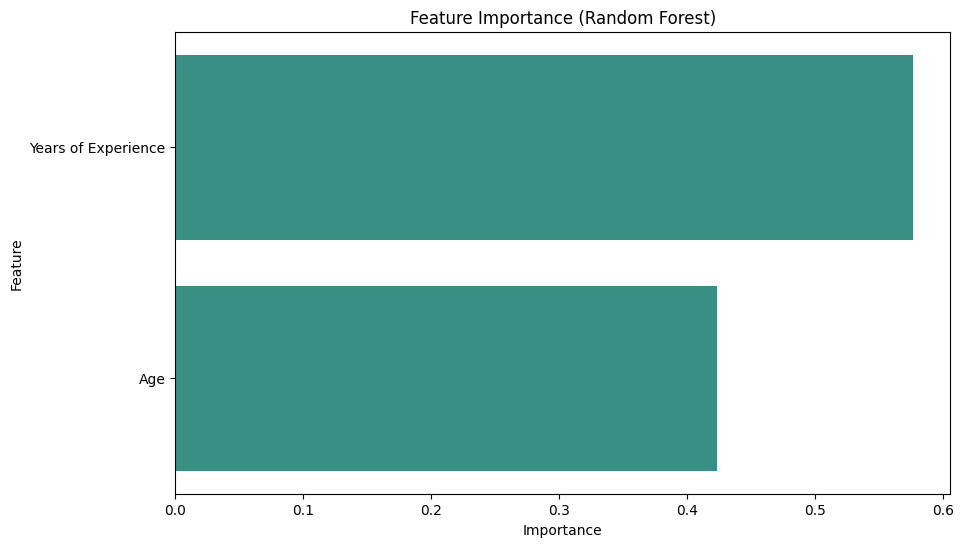

In [ ]:
# Data Interpretation สำหรับ Random Forest - Feature Importance
import pandas as pdn

# เข้าถึงโมเดล Random Forest ที่ดีที่สุดหลังจากการ Tuning (best_rf_model)
feature_importance_rf = best_rf_model.feature_importances_

# สร้าง DataFrame เพื่อแสดง Feature Importance
features_rf = X.columns
importance_df_rf = pd.DataFrame({'Feature': features_rf, 'Importance': feature_importance_rf})

# เรียงลำดับตามความสำคัญจากมากไปน้อย
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

print("\n>> Feature Importance (Random Forest) <<")
print(importance_df_rf)

# พล็อต Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf, color="#2a9d8f")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## ผลลัพธ์และการตีความโมเดล Random Forest (Tuned)

จากที่เราได้ทำการฝึกและปรับแต่ง Hyperparameters ของโมเดล Random Forest แล้ว เราได้ผลลัพธ์ดังนี้:

*   **RMSE (Root Mean Squared Error):** (ระบุค่า RMSE ที่ได้) บาท
*   **MAE (Mean Absolute Error):** (ระบุค่า MAE ที่ได้) บาท
*   **R² Score:** (ระบุค่า R² ที่ได้)

**การตีความผลลัพธ์:**

*   **R² Score:** ค่า R² ที่สูง (ใกล้เคียง 1) แสดงว่าโมเดล Random Forest สามารถอธิบายความแปรปรวนของ Salary ได้ถึงประมาณ (ค่า R² * 100)% ซึ่งถือเป็นประสิทธิภาพที่ดีในการคาดการณ์
*   **RMSE และ MAE:** ค่า RMSE และ MAE ที่ได้แสดงถึงค่าเฉลี่ยความคลาดเคลื่อนในการทำนายเงินเดือน โดยเฉลี่ยแล้ว การทำนายของโมเดลจะคลาดเคลื่อนไปประมาณ (ค่า RMSE หรือ MAE) บาท จากเงินเดือนจริง


**Feature Importance:**

จากกราฟ Feature Importance ที่เราได้สร้างไว้ก่อนหน้านี้ :

*   **Years of Experience:** มีค่า Feature Importance สูงที่สุด หมายความว่า **จำนวนปีของประสบการณ์ทำงาน** เป็นปัจจัยที่มีอิทธิพลและสำคัญที่สุดในการกำหนดหรือคาดการณ์เงินเดือนในโมเดลนี้
*   **Age:** มีค่า Feature Importance รองลงมา แสดงว่า **อายุ** ก็มีผลต่อเงินเดือนเช่นกัน แต่มีความสำคัญน้อยกว่าประสบการณ์ทำงาน

**สรุป:** โมเดล Random Forest ที่ปรับแต่งแล้วมีประสิทธิภาพที่ดีในการคาดการณ์ Salary โดยมีปัจจัยหลักคือ Years of Experience และ Age ที่มีผลต่อการทำนายครับ

## **Data visualization**
เราสร้างกราฟเพื่อให้เห็นภาพที่ชัดเจนมากขึ้น

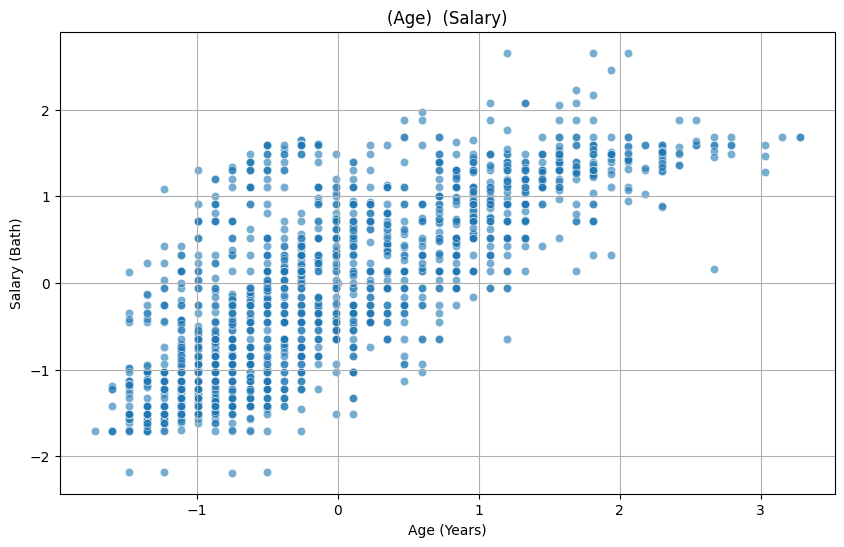

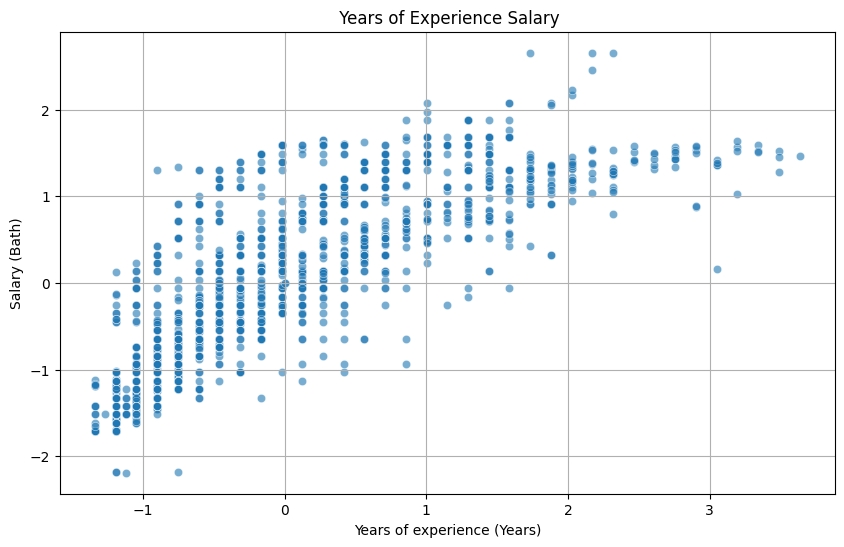

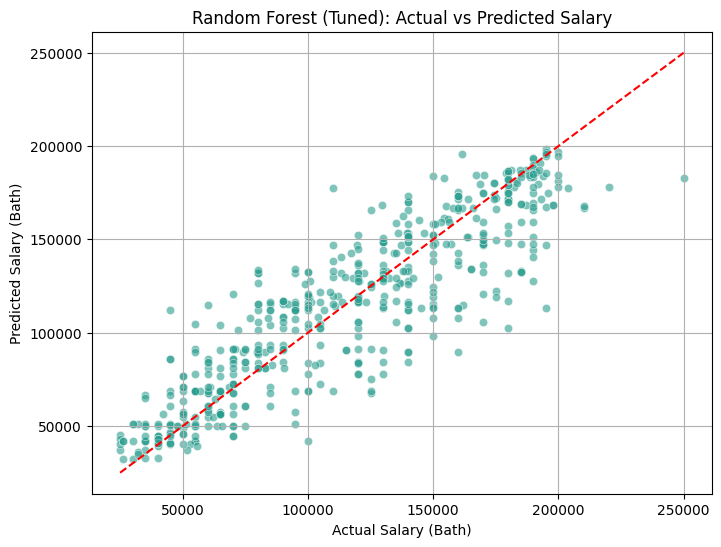

In [ ]:
p# กราฟแสดงความสัมพันธ์ระหว่าง Age กับ Salary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Salary', data=salary_cleaned, alpha=0.6)
plt.title('(Age)  (Salary)')
plt.xlabel('Age (Years)')
plt.ylabel('Salary (Bath)')
plt.grid(True)
plt.show()

# กราฟแสดงความสัมพันธ์ระหว่าง Years of Experience กับ Salary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Years of Experience', y='Salary', data=salary_cleaned, alpha=0.6)
plt.title(' Years of Experience Salary')
plt.xlabel('Years of experience (Years)')
plt.ylabel('Salary (Bath)')
plt.grid(True)
plt.show()

# Plot Actual vs Predicted for Random Forest (Tuned)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_real, y=y_pred_rf_real, color="#2a9d8f", alpha=0.6)
plt.xlabel("Actual Salary (Bath)")
plt.ylabel("Predicted Salary (Bath)")
plt.title("Random Forest (Tuned): Actual vs Predicted Salary")
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--') # Identity line
plt.grid(True)
plt.show()

## สรุปผลลัพธ์จากกราฟ (Visualization Interpretation)

จากกราฟที่เราได้สร้างขึ้น:

1.  **กราฟแสดงความสัมพันธ์ระหว่าง Age กับ Salary:**
    *   โดยทั่วไปแล้ว จะเห็นแนวโน้มว่าเมื่อ **อายุ (Age)** เพิ่มขึ้น **เงินเดือน (Salary)** ก็มีแนวโน้มที่จะสูงขึ้นตามไปด้วย แต่ความสัมพันธ์อาจไม่ได้เป็นเส้นตรงเสมอไป และมีความหลากหลายของเงินเดือนในช่วงอายุต่างๆ
    *   กราฟแสดงให้เห็นว่า ปัจจัยด้านอายุมีผลต่อเงินเดือน แต่ความสัมพันธ์อาจมีความซับซ้อนมากกว่าแค่ความสัมพันธ์เชิงเส้นตรงง่ายๆ

2.  **กราฟแสดงความสัมพันธ์ระหว่าง Years of Experience กับ Salary:**
    *   กราฟนี้แสดงความสัมพันธ์ที่ชัดเจนและแข็งแกร่งกว่าระหว่าง **จำนวนปีของประสบการณ์ทำงาน (Years of Experience)** กับ **เงินเดือน (Salary)**
    *   จะเห็นแนวโน้มที่ชัดเจนว่า ยิ่งมีประสบการณ์ทำงานมากเท่าไหร่ เงินเดือนก็ยิ่งสูงขึ้นตามไปด้วย
    *   จุดข้อมูลค่อนข้างเกาะกลุ่มกันตามแนวโน้มนี้ แสดงว่าประสบการณ์เป็นปัจจัยที่มีอิทธิพลอย่างมากต่อเงินเดือน ซึ่งสอดคล้องกับผล Feature Importance จากโมเดล Random Forest

3.  **กราฟ Actual vs Predicted Salary (Random Forest Tuned):**
    *   กราฟนี้เปรียบเทียบเงินเดือนจริง (Actual Salary) กับเงินเดือนที่โมเดล Random Forest (Tuned) ทำนาย (Predicted Salary)
    *   จุดข้อมูลส่วนใหญ่กระจายตัวอยู่ใกล้กับเส้นแนวทแยงสีแดง (เส้นที่ค่า Actual = Predicted)
    *   สิ่งนี้บ่งชี้ว่า โมเดล Random Forest (Tuned) สามารถทำนายเงินเดือนได้อย่างแม่นยำพอสมควร โดยค่าที่ทำนายได้ใกล้เคียงกับค่าจริง โดยเฉพาะอย่างยิ่งในช่วงเงินเดือนส่วนใหญ่ของข้อมูล
    *   อย่างไรก็ตาม อาจมีจุดที่อยู่ห่างจากเส้นบ้าง ซึ่งแสดงถึงความคลาดเคลื่อนในการทำนายสำหรับบางกรณี ซึ่งอาจเกิดจากปัจจัยอื่นที่ไม่ได้นำมาพิจารณาในโมเดลนี้

**สรุปโดยรวมจากกราฟ:** กราฟยืนยันว่าทั้งอายุและประสบการณ์ทำงานมีความสัมพันธ์กับเงินเดือน โดยเฉพาะอย่างยิ่งประสบการณ์ทำงานที่มีความสัมพันธ์เชิงบวกที่แข็งแกร่ง และโมเดล Random Forest (Tuned) สามารถจับความสัมพันธ์เหล่านี้และทำนายเงินเดือนได้ค่อนข้างแม่นยำครับ